Draft for CEE 306 module <br>
Reference ET calculation for FAO-56 <br>
Editing and expanding on 12/23 upload<br>
<br><br>
I included the single crop K_c curve method based on Tables 11 and 12 with no adjustments. I think the adjustments are outside the scope of this notebook. The last cell in this file notes how crop ET can be decomposed as transpiration + bare soil evaporation, but I am not sure it is worth incorporating an exercise on this into the code. For example, FAO-56 Eq(71) covers the evaporation factor of crop ET but does not look like a useful learning exercise. <br>
I added blank lines and comments for parameters that the student ought to try changing.<br>
I re-organized the flow into something I believe makes sense. Starts with solar radiation, then goes into air temperature and water vapor content, which leads to net long-wave and wraps up net radiation, then mean saturation vapor pressure and the slope $\Delta$, then wind and the psychrometric constant before getting ET0. Then two $K_c$ curves are constructed to find ETc.<br>
This might just be a quirk of working on my iPad, but I switched all "Text" cells to "Markdown" and it is looking better.

In [1]:
import math

This notebook follows the [FAO-56] (https://www.fao.org/3/x0490e/x0490e00.htm#Contents) methodology which implements the Penman approach to ET, to get a reference $ET_0$ (often called potential ET) value.
It then uses crop coefficients to scale $ET_0$ to some actual ET on cropland during the growing season.

# Overall Game Plan

This document outlines the FAO-56 approach which is useful when there are limited observations. We will calculate a theoretical solar radation budget, we will calculate vapor pressure based only on temperature (minimum and maximum), then we will calculate the slope of the vapor pressure curve ($\Delta$) and psychrometric constant ($\gamma$) which are foundational components to the Penman equation. Each of the supporting calculations are arranged in sections.  If you have observations for (e.g.) long and shortwave net radiation, you would generally use those in place of the theoretical calculations shown here.

# Calculate the net solar radiation

A majority of the calculations in FAO-56 and in codes like PRMS are to estimate the net solar radiation.  This uses the equations we developed earlier in the class for theoretical net solar short and long wave radiation (e.g. 2.6.1 in Brutsaert).ß. <br>For daily periods, extraterrestrial radiation can be calculated using the solar constant, the relative Earth-Sun distance, the sunset hour angle, the latitude, and the solar declination angle with FAO-56 Eq(21).

In [2]:
#Extraterrestrial radiation = Ra
Gsc = 0.0820 #[MJ/(m^2*min)], Solar Constant

#try experimenting with this parameter
DOY = 275 #day of year after Jan 1 (less than 366)

dr = 1+0.033*math.cos(2*math.pi*DOY/365) #relative Earth-Sun distance
sd = 0.409*math.sin(2*math.pi*DOY/365 - 1.39) #[rad], solar declination angle

#try experimenting with this parameter
j = math.pi/6 #[rad], latitude angle, positive north of equator

ws = math.acos(-math.tan(j)*math.tan(sd)) #[rad], sunset hour angle
Ra = (24*60/math.pi)*Gsc*dr*(ws*math.sin(j)*math.sin(sd)+math.cos(j)*math.cos(sd)*math.sin(ws))
print('Extraterrestrial Solar Radiation')
print('Ra =',Ra,'MJ/(m^2*day)')

Extraterrestrial Solar Radiation
Ra = 30.075308703074718 MJ/(m^2*day)


So that is how much solar radiation is reaching the top of atmosphere, but what is actually touching the ground? We need to estimate how much is lost in the atmosphere. For that we can use FAO-56 Eq(35) which uses two constants and the day's relative hours of sunlight.

In [3]:
N = 24*ws/math.pi #maximum daylight hours given sunshine hour angle
print('Maximum daylight hours for location and date')
print('N =',N,'hours') #check N before deciding n

Maximum daylight hours for location and date
N = 11.636565159876357 hours


In [4]:
#try experimenting with this parameter
n = 10 #actual sunshine hours (must be less than N)

a_s = 0.25 #recommended Angstrom constant
b_s = 0.55 #recommended Angstrom constant
Rs = (a_s+b_s*(n/N))*Ra #Solar Radiaton at ground
print('Solar radiation at the ground')
print('Rs =',Rs,'[MJ/(m^2*day)]')

Solar radiation at the ground
Rs = 21.733863622887114 [MJ/(m^2*day)]


If n = N (and it is clear sky conditions all day) then <br>$R_{so} = (a_s + b_s)*R_a$ (FAO-56 Eq36)

In [5]:
#Clear sky solar radiation
Rso = (a_s+b_s)*Ra
print('Maximum solar radiation at the ground')
print('Rso =',Rso,'[MJ/(m^2*day)]')

Maximum solar radiation at the ground
Rso = 24.060246962459775 [MJ/(m^2*day)]


Finally, net solar radiation is what comes to the ground minus what gets reflected. Albedo tells us what fraction gets reflected, so net short wave radiation is <br>$R_{ns} = R_s*(1-albedo)$

In [6]:
#try experimenting with this parameter
albedo = 0.3

Rns = Rs*(1-albedo)
print('Solar radiation absorbed at the ground')
print('Rns =',Rns,'[MJ/(m^2*day)]')

Solar radiation absorbed at the ground
Rns = 15.213704536020979 [MJ/(m^2*day)]


# Air temperature data

Before calculating the long-wave portion of the radiation budget, we need to know the average air temperature. We will approximate the average assuming it is right in between the minimum and maximum temperature. We also need to find the vapor pressure.

In [7]:
#try experimenting with these parameters
Tmin = 15  #deg C, minimum temperature
Tmax = 25  #deg C, maximum temperature

Tmean = (Tmax+Tmin)/2 #[C]
print('Mean air temperature')
print('T_mean =',Tmean,'deg C')

Mean air temperature
T_mean = 20.0 deg C


# Calculate dew-point temperature, $T_{dew}$

Dew-point temperature is the temperature at which a parcel of air is fully saturated with water so that droplets (dew) start to form. When there are no observations of relative humidity, we can use an estimate based on the minimum daily temperature, $T_{min}$ (this is one reason is why many products, e.g. DayMET, report min/max temps).  <br>$T_{dew} = T_{min} - K_0$ <br>where the empirical dewpoint offset, $K_0 = 2$ \[deg C].

In [8]:
K0=2 #dewpoint offset, empirical. Should be between 0 and 2
Tdew=Tmin-K0
print('Dew-point Temperature')
print('Tdew =',Tdew,'deg C')

Dew-point Temperature
Tdew = 13 deg C


# Calculate actual vapor pressure, $e_a$

Vapor pressure is the partial pressure of water vapor within air. Saturation vapor pressure is the vapor pressure of an air parcel at some temperature when it has plenty of water. As seen in FAO-56 Eq(10), actual vapor pressure is the saturation vapor pressure times relative humidity. Since dew-point temperature is the temp at which air is saturated, then RH = 100% and the actual vapor pressure at the dew-point temperature is equal to the saturation vapor pressure at that temperature. We use FAO-56 Eq(14) to calculate this as <br>$e_a=e_0(T_{dew})$ \[kPa] or <br>$e_a=0.6108*e^{(17.27*T_{dew})/(T_{dew}+237.3)}$

In [9]:
ea=0.6108*math.exp((17.27*Tdew)/(Tdew+237.3))  #[kPa]
print('Actual vapor pressure')
print('ea =',ea,'kPa')

Actual vapor pressure
ea = 1.4977709027569757 kPa


# Calculate net longwave radiation

FAO-56 Eq(39) details an approach to estimating net long-wave radiation out. Long-wave radiation is energy emitted at Earth temperatures (much cooler than the Sun and thereby longer wavelengths). Net long-wave is defined in FAO-56 as radiation emitted up by the surface minus radiation emitted down by the atmosphere. The atmospheric emission depends strongly on water content, so the equation incorporates $e_a$. Actual and maximum solar radiation at the ground, Rs and Rso, also show up in the equation.

In [10]:
s = 4.903E-9 #MJ/(K^4*m^2) Stefan Boltzmann Constant
Rnl = s*(((Tmin+273.16)**4+(Tmax+273.16)**4)/2)*(0.34-0.14*math.sqrt(ea))*(1.35*Rs/Rso-0.35)
print('Net long-wave radiation up')
print('Rnl =',Rnl,'[MJ/(m^2*day)]')

Net long-wave radiation up
Rnl = 5.320007916862334 [MJ/(m^2*day)]


# Calculate net radiation

Net radiation is simply the balance of short and long-wave radiation. Since our short-wave was positive into the ground and our long-wave was positive out of the ground, FAO-56 Eq(40) writes <br>$R_n = R_{ns} - R_{nl}$. <br>Net radiation ought to include ground heat flux, but we will assume it is zero.

In [11]:
Rn = Rns - Rnl #this energy, Rn, drives ET
print('Net radiation at the surface')
print('Rn =',Rn,'[MJ/(m^2*day)]')

Net radiation at the surface
Rn = 9.893696619158645 [MJ/(m^2*day)]


# Calculate the saturation vapor pressure, $e_{s}$, and then the vapor pressure deficit, $e_{s}-e_{a}$

Saturation vapor pressure is the partial pressure of water vapor within air when relative humidity is 100%. Because the saturation vapor pressure equation is non-linear, the average should first calculate the saturation vapor pressure at the minimum and maximum temperature, and then average the results.<br>$e_s=(e_0(T_{max})+e_0(T_{min}))/2$ \[kPa] (FAO-56 Eq12).<br> Vapor pressure deficit is then the difference between the saturated and actual vapor pressures.

In [12]:
e0_Tmax=0.6108*math.exp((17.27*Tmax)/(Tmax+237.3))  #[kPa]
e0_Tmin=0.6108*math.exp((17.27*Tmin)/(Tmin+237.3))  #[kPa]
es=(e0_Tmax+e0_Tmin)/2 #[kPa]
print('Saturated vapor pressure')
print('es =',es,'kPa\n')
print('Vapor pressure deficit')
print('VPD =',es-ea,'kPa')

Saturated vapor pressure
es = 2.4365619748113096 kPa

Vapor pressure deficit
VPD = 0.938791072054334 kPa


# Calculate the slope of the vapor pressure curve, $\Delta$

The slope of the vapor pressure curve, $\Delta$, or D, is quite simply the derivative or rise/run of FAO-56 Eq(11) for saturation vapor pressure as a function of temperature. D in units of kPa per degree C is listed in FAO-56 Eq(13) as
<br>$D=4096*0.6108*e^{(17.27*T/(T+237.3)))/(T+237.3)^2}$ <br>We can take the slope at the mean temperature.

In [13]:
D=4096*(0.6108*math.exp(17.27*Tmean/(Tmean+237.3)))/(Tmean+237.3)**2
print('Slope of saturation vapor pressure')
print('$\Delta$','=',D,'kPa/C')

Slope of saturation vapor pressure
$\Delta$ = 0.14466954868434512 kPa/C


# Calculate the wind speed 2 meters above the ground, $u_2$

Wind tends to have a logarithmic profile with zero wind exactly at the ground, and faster winds higher up. Our equation requires us to have the wind 2 meters above the ground. FAO-56 Eq(47) gives the wind at 2 meters given wind measured at some height, $u_z$ and $z$.

In [14]:
#try experimenting with these values
uz = 3.5 #[m/s], wind at something other than 2 m
z = 3 #[m], height at which uz was measured

u2 = uz*4.87/math.log(67.8*z-5.42)
print('Wind 2 meters above ground')
print('u2 =',u2,'m/s')

Wind 2 meters above ground
u2 = 3.2232346620863908 m/s


# Calculate the psychrometric constant, $\gamma$

The psychrometric constant is so named because it is essentially a constant for most atmospheric conditions. However, Dingman 3rd Edition Eq(6.21) explains what goes into the parameter. Where $c_a$ is the heat capacity of air, $p$ is pressure, $\lambda_v$ is the heat of vaporization, and $0.622$ is the ratio of the gas constants for air and water vapor, <br>$\gamma = (c_a * p)/(0.622 * \lambda_v)$

In [15]:
# typical values that go into the psychrometric constant are 
c_a = 10**(-3) #MJ/(kg*K)
p = 101.3 #kPa
lv = 2.47 #MJ/kg
psychro = c_a*p/(0.622*lv)
print('Psychrometric constant')
print('$\gamma$ =',psychro,'kPa/K = kPa/C' )

Psychrometric constant
$\gamma$ = 0.06593592564145957 kPa/K = kPa/C


# Calculate reference evapotranspiration, $ET_0$

FAO-56 Eq(6) uses the same units for the above terms as given here to get a reference ET in mm/day.<br>
$ET_0=(0.408*\Delta*R_n+\gamma*(900/(T_{mean}+273))*u_2*(e_s-e_a))/(\Delta+\gamma*(1+0.34*u_2))$

In [16]:
ET0 = (0.408*D*Rn+psychro*(900/(Tmean+273))*u2*(es-ea))/(D+psychro*(1+0.34*u2))
print('Reference evapotranspiration')
print('ET_0 =',ET0,'mm/day')

Reference evapotranspiration
ET_0 = 4.231113417385911 mm/day


By this final potential ET equation, we see that increased radiation, wind speed, and vapor pressure deficit all increase the potential for the atmosphere to evaporate moisture from the ground surface or from plants.

# Translate potential ET, $ET_0$, into crop ET, $ET_c$, under standard conditions

$ET_c=K_c*ET_0$ 

Crop ET is equal to potential ET times a crop factor, $K_c$. The crop coefficient, $K_c$, can be larger than 1 due to agricultural crops' tendency for being tightly packed and tall growing. Some crops like pineapple and agave close their stomata during the day and have very small $K_c$ values, but most plants evaporate significantly during photosynthesis throughout the day.<br>

The soil evaporation portion of crop ET depends largely on how much the crop covers the ground. If the crop leaves a lot of soil bare, then soil evaporation will be large if water and energy are available. For this exercise, we will find $K_c$ values for a crop's four phases (initial, development, mid, and late) given tabulated values and then multiply it to our $ET_0$ value.

# Construct a $K_c$ curve for carrots grown in California

For a crop coefficient curve that lets us find $K_c$ for any day of the year (DOY) assuming typical agricultural conditions, we need to know the planting date, length of crop phases, and $K_c$ of each phase.<br>Planting date and crop phase durations are found in FAO-56 Table 11, and $K_c$ values for each phase are found in Table 12. Both tables list a significant variety of crops.<br> For carrots grown in CA, from Table 11 we find that day length of the initial phase is 30, development is 50, mid is 90, and late is 30, for a total of 200 days of the year. Planting is listed to start in Oct, so we will take Oct 1st which is the 274th DOY. From Table 12, we find that carrots have an initial $K_c$ of 0.7, a mid $K_c$ of 1.05, and an end $K_c$ of 0.95. Their maximum crop height is 0.3 m which we do not need for this simple approach.

<br>The ending $K_{c}$ values represent once the crop is fully harvested, so outside of the agricultural period, we will represent $K_c$ as 0. To plot $K_c$, we will incorporate the data from Tables 11 and 12 to plot against the $DOY$.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
k_c_init = 0.7 #initial phase Kc value
k_c_mid = 1.05 #mid phase Kc value
k_c_end = 0.95 #ending Kc value

L_init = 30 #days of initial phase
L_dev = 50 #days of development phase
L_mid = 90 #days of mid phase
L_late = 30 #days of late phase
d_start = 274 #day of year planted

day = np.arange(1,366,1) #create an array that goes through all 365 days
k_c_day = np.zeros(365) #create an array of zeros for K_c of each day of the year

for i in range(len(day)):
    j = i + d_start #use i to track the crop phases, j to track DOY
    if j >= 365:
        j = j - 365 #adjust to fit j on one calendar year
        
    if i < L_init: #initial phase
        k_c_day[j] = k_c_init #constant K_c in this phase
        
    if L_init <= i < L_init + L_dev: #development phase
        k_c_day[j] = k_c_init + (k_c_mid-k_c_init)*(i-L_init)/L_dev #sloped K_c in this phase
        
    if L_init + L_dev <= i < L_init + L_dev + L_mid: #mid phase
        k_c_day[j] = k_c_mid #constant K_c in this phase
        
    if L_init + L_dev + L_mid <= i < L_init + L_dev + L_mid + L_late: #late phase
        k_c_day[j] = k_c_mid + (k_c_end-k_c_mid)*(i-L_init-L_dev-L_mid)/L_late #sloped K_c in this phase  

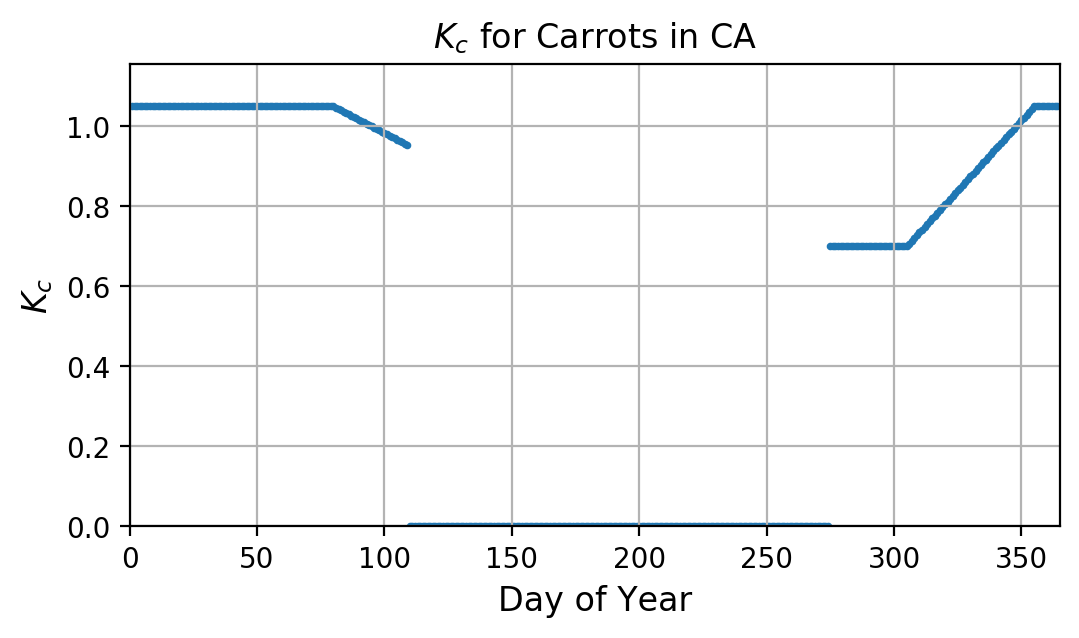

In [19]:
plt.figure(figsize=(6,3))
plt.scatter(day,k_c_day,s=3)
plt.ylabel('$K_c$', fontsize=12)
plt.xlabel('Day of Year',fontsize=12)
plt.xlim([0,365])
plt.ylim([0,1.1*k_c_mid])
plt.title('$K_c$ for Carrots in CA')
plt.grid()

# Use the day of year from the solar energy section to find $K_c[DOY]$

In [20]:
K_c = k_c_day[DOY]
print('DOY = the',DOY,'day of the year')
print('K_c =',K_c,'= crop coefficient on DOY')

DOY = the 275 day of the year
K_c = 0.7 = crop coefficient on DOY


# If DOY is in the growing season, calculate $ET_c$

In [21]:
print('ET_0 =',ET0,'mm/day')
if K_c > 0:
    ETc = K_c * ET0
    print('ET_c =',ETc,'mm/day')
else:
    print('DOY is outside the growing season, ETc is an inappropriate approach')

ET_0 = 4.231113417385911 mm/day
ET_c = 2.9617793921701376 mm/day


# Construct a $K_c$ curve for egg-plant in a Mediterranean climate and calculate $ET_c$

Some more crop data is egg-plant in a Mediterranean climate where<br>
k_c_init = 0.6<br>
k_c_mid = 1.05<br>
k_c_end = 0.9<br>
<br>
L_init = 30<br>
L_dev = 45<br>
L_mid = 40<br>
L_late = 25<br>
d_start = 152 #June 1st

In [22]:
k_c_init = 0.6 #initial phase Kc value
k_c_mid = 1.05 #mid phase Kc value
k_c_end = 0.9 #ending Kc value

L_init = 30 #days of initial phase
L_dev = 45 #days of development phase
L_mid = 40 #days of mid phase
L_late = 25 #days of late phase
d_start = 152 #day of year planted

day = np.arange(1,366,1) #create an array that goes through all 365 days
k_c_day = np.zeros(365) #create an array of zeros for K_c of each day of the year

for i in range(len(day)):
    j = i + d_start #use i to track the crop phases, j to track DOY
    if j >= 365:
        j = j - 365 #adjust to fit j on one calendar year
        
    if i < L_init: #initial phase
        k_c_day[j] = k_c_init #constant K_c in this phase
        
    if L_init <= i < L_init + L_dev: #development phase
        k_c_day[j] = k_c_init + (k_c_mid-k_c_init)*(i-L_init)/L_dev #sloped K_c in this phase
        
    if L_init + L_dev <= i < L_init + L_dev + L_mid: #mid phase
        k_c_day[j] = k_c_mid #constant K_c in this phase
        
    if L_init + L_dev + L_mid <= i < L_init + L_dev + L_mid + L_late: #late phase
        k_c_day[j] = k_c_mid + (k_c_end-k_c_mid)*(i-L_init-L_dev-L_mid)/L_late #sloped K_c in this phase  

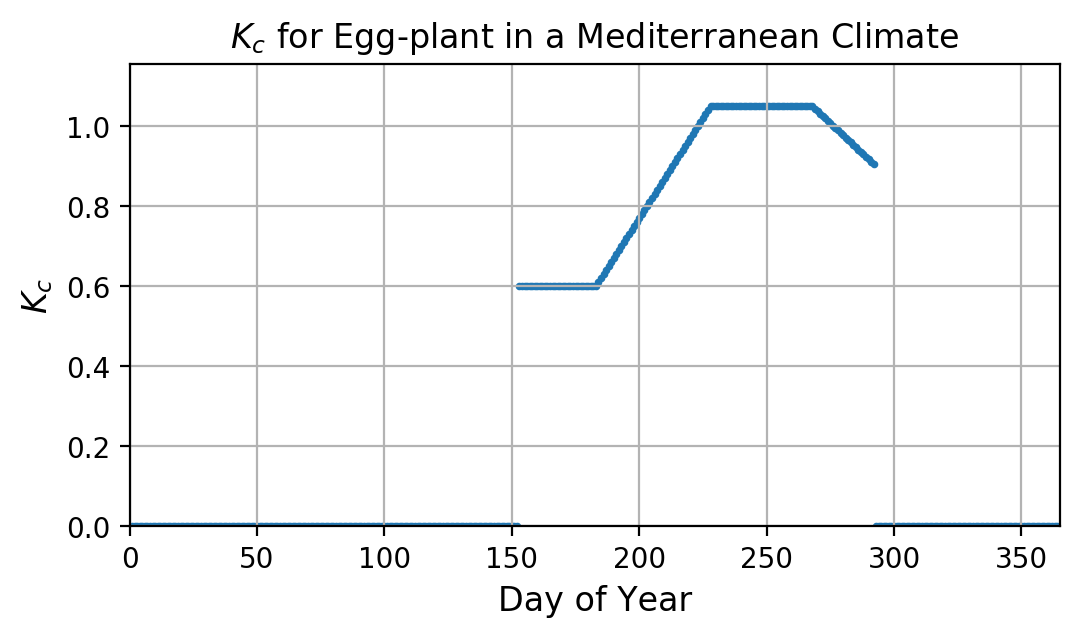

In [23]:
plt.figure(figsize=(6,3))
plt.scatter(day,k_c_day,s=3)
plt.ylabel('$K_c$', fontsize=12)
plt.xlabel('Day of Year',fontsize=12)
plt.xlim([0,365])
plt.ylim([0,1.1*k_c_mid])
plt.title('$K_c$ for Egg-plant in a Mediterranean Climate')
plt.grid()

# Use the day of year from the solar energy section to find $K_c[DOY]$

In [24]:
K_c = k_c_day[DOY]
print('DOY = the',DOY,'day of the year')
print('K_c =',K_c,'= crop coefficient on DOY')

DOY = the 275 day of the year
K_c = 1.002 = crop coefficient on DOY


# If DOY is in the growing season, calculate $ET_c$

In [25]:
print('ET_0 =',ET0,'mm/day')
if K_c > 0:
    ETc = K_c * ET0
    print('ET_c =',ETc,'mm/day')
else:
    print('DOY is outside the growing season, ETc is an inappropriate approach')

ET_0 = 4.231113417385911 mm/day
ET_c = 4.239575644220683 mm/day


Of course actual ET values depend on soil moisture and fine-scale weather conditions, but the annual $K_c$ curves with no adjustments give a good estimate of ET from crops on a given day. Crop ET can really be decomposed into transpiration and evaporation where transpiration is water leaving through the plants and evaporation is water leaving through bare soil. The evaporation component is largely dependent on the most previous rainfall or irrigation event and how much of that has already dried up.